In [1]:
import lightgbm as lgb
import numpy as np
import pandas as pd

from IPython.display import display
from scipy.stats import zscore
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.feature_selection import SelectFromModel
from sklearn.mixture import GaussianMixture
from sklearn.linear_model import LogisticRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneOut
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import mutual_info_classif
from sklearn.metrics import balanced_accuracy_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import auc
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import roc_auc_score

from xgboost import XGBClassifier

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [12]:
models = {'gmm': {'classifier': GaussianMixture(),
                  'params': {'n_components'   : [2],
                             'n_init'         : [3],
                             'covariance_type': ['full', 'tied', 'diag', 'spherical']}},
          'logit': {'classifier': LogisticRegression(max_iter=5000, tol=1e-6, solver='liblinear'),
                    'params': {'class_weight': ['balanced'],
                               'penalty' : ['l1', 'l2'],
                               'C'       : [0.1, 0.5, 1.0]}},
          'random_forest': {'classifier': RandomForestClassifier(),
                            'params': {'class_weight' : ['balanced'],
                                       'n_estimators' : [200],
                                       'max_features' : [2, 3, 4, 5],
                                       'max_depth'    : [2, 3, 5]}},
          #'lda': {'classifier': LinearDiscriminantAnalysis(),
          #        'params': {'n_components': [2]}},
          #'naive_bayes': {'classifier': GaussianNB(),
          #                'params': None},
          'svc': {'classifier': SVC(),
                  'params': {'kernel': ['poly', 'rbf'],
                             'class_weight': ['balanced']}}
         }

In [3]:
def gridsearch_select(estimator, X, y, param_grid, cv=LeaveOneOut(), metric='balanced_accuracy_score', n_jobs=-1):
    pipe = Pipeline([('rf_select', SelectFromModel(RandomForestClassifier(n_estimators=200))), 
                     ('clf', estimator)]) 
    clf = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring=metric, refit='acc', n_jobs=n_jobs,
                       return_train_score=True, error_score=np.nan)
    clf.fit(X, y);
    return clf

In [4]:
df = pd.read_csv('/home/pdaly/supereeg/data/apr6_100samp_2h_ml/df.csv', index_col=0)

X = pd.DataFrame(PCA().fit_transform(df.drop('dep', axis=1).apply(zscore)))
y = df['dep']

In [14]:
pd.DataFrame(clf.cv_results_).columns

Index(['mean_fit_time', 'mean_score_time', 'mean_test_acc', 'mean_test_prec',
       'mean_test_rec', 'mean_train_acc', 'mean_train_prec', 'mean_train_rec',
       'param_clf__C', 'param_clf__class_weight',
       ...
       'split9_train_prec', 'split9_train_rec', 'std_fit_time',
       'std_score_time', 'std_test_acc', 'std_test_prec', 'std_test_rec',
       'std_train_acc', 'std_train_prec', 'std_train_rec'],
      dtype='object', length=270)

In [13]:
all_results = dict()

for family in models:
    
    print('Model: {}'.format(family))
    
    estimator = models[family]['classifier']
    params = models[family]['params']

    param_grid = {'clf__' + key: val for key, val in params.items()}
    param_grid['rf_select__max_features'] = [5, 7, 10]

    metrics = {'acc': 'balanced_accuracy', 'prec': 'precision', 'rec': 'recall'}
    clf = gridsearch_select(estimator, X, y, param_grid=param_grid, metric=metrics, n_jobs=10)
    results_cols = ['param_' + key for key in param_grid] + ['mean_train_acc', 'mean_test_acc', 'mean_train_rec', 
                                                             'mean_test_rec', 'mean_train_rec', 'mean_test_rec']
    results = pd.DataFrame(clf.cv_results_)[results_cols].sort_values('mean_test_acc', ascending=False)
    display(results.head(10))
    all_results[family] = results

Model: gmm


,param_rf_select__max_features,param_clf__covariance_type,param_clf__n_components,param_clf__n_init,mean_train_acc,mean_test_acc,mean_train_rec,mean_test_rec,mean_train_rec,mean_test_rec
4,7,tied,2,3,0.488997,0.536585,0.340499,0.219512,0.340499,0.219512
6,5,diag,2,3,0.489122,0.536585,0.278897,0.195122,0.278897,0.195122
10,7,spherical,2,3,0.500073,0.536585,0.325509,0.195122,0.325509,0.195122
1,7,full,2,3,0.490021,0.512195,0.370047,0.219512,0.370047,0.219512
11,10,spherical,2,3,0.495903,0.487805,0.479611,0.243902,0.479611,0.243902
3,5,tied,2,3,0.472163,0.463415,0.212619,0.121951,0.212619,0.121951
7,7,diag,2,3,0.485068,0.463415,0.226791,0.121951,0.226791,0.121951
5,10,tied,2,3,0.455869,0.439024,0.295286,0.146341,0.295286,0.146341
8,10,diag,2,3,0.482135,0.439024,0.259424,0.121951,0.259424,0.121951
9,5,spherical,2,3,0.485688,0.439024,0.236720,0.146341,0.236720,0.146341


Model: svc


,param_clf__kernel,param_rf_select__max_features,param_clf__class_weight,mean_train_acc,mean_test_acc,mean_train_rec,mean_test_rec,mean_train_rec,mean_test_rec
4,rbf,7,balanced,0.835909,0.731707,0.861997,0.439024,0.861997,0.439024
5,rbf,10,balanced,0.840736,0.731707,0.867348,0.439024,0.867348,0.439024
3,rbf,5,balanced,0.830071,0.658537,0.848887,0.390244,0.848887,0.390244
0,poly,5,balanced,0.677417,0.609756,0.989299,0.536585,0.989299,0.536585
1,poly,7,balanced,0.669831,0.609756,0.997879,0.536585,0.997879,0.536585
2,poly,10,balanced,0.672683,0.609756,0.995614,0.536585,0.995614,0.536585


Model: random_forest


,param_clf__max_depth,param_clf__n_estimators,param_rf_select__max_features,param_clf__max_features,param_clf__class_weight,mean_train_acc,mean_test_acc,mean_train_rec,mean_test_rec,mean_train_rec,mean_test_rec
6,2,200,5,4,balanced,0.918660,0.731707,0.910730,0.414634,0.910730,0.414634
13,3,200,7,2,balanced,0.986431,0.707317,0.972862,0.463415,0.972862,0.463415
34,5,200,7,5,balanced,1.000000,0.682927,1.000000,0.463415,1.000000,0.463415
4,2,200,7,3,balanced,0.934773,0.682927,0.928131,0.414634,0.928131,0.414634
5,2,200,10,3,balanced,0.965746,0.682927,0.952135,0.414634,0.952135,0.414634
7,2,200,7,4,balanced,0.932585,0.682927,0.924949,0.414634,0.924949,0.414634
8,2,200,10,4,balanced,0.963433,0.682927,0.947749,0.439024,0.947749,0.439024
9,2,200,5,5,balanced,0.926157,0.682927,0.911935,0.365854,0.911935,0.365854
17,3,200,10,3,balanced,0.997178,0.682927,0.995710,0.463415,0.995710,0.463415
16,3,200,7,3,balanced,0.985347,0.682927,0.970693,0.414634,0.970693,0.414634


Model: logit


,param_clf__class_weight,param_rf_select__max_features,param_clf__penalty,param_clf__C,mean_train_acc,mean_test_acc,mean_train_rec,mean_test_rec,mean_train_rec,mean_test_rec
14,balanced,10,l1,1,0.827238,0.829268,0.864263,0.487805,0.864263,0.487805
13,balanced,7,l1,1,0.826683,0.829268,0.863154,0.487805,0.863154,0.487805
9,balanced,5,l2,0.5,0.823343,0.804878,0.832642,0.463415,0.832642,0.463415
10,balanced,7,l2,0.5,0.832975,0.804878,0.843536,0.463415,0.843536,0.463415
16,balanced,7,l2,1,0.838599,0.804878,0.846814,0.463415,0.846814,0.463415
11,balanced,10,l2,0.5,0.823680,0.804878,0.841367,0.463415,0.841367,0.463415
15,balanced,5,l2,1,0.832447,0.780488,0.851248,0.463415,0.851248,0.463415
12,balanced,5,l1,1,0.825502,0.780488,0.856647,0.463415,0.856647,0.463415
17,balanced,10,l2,1,0.840015,0.780488,0.852116,0.463415,0.852116,0.463415
8,balanced,10,l1,0.5,0.821258,0.780488,0.827196,0.463415,0.827196,0.463415


In [ ]:
# null model


null_results = {'rs': list(), 'ps': list(), 'acc': list(), 'bacc': list(), 'roc': list()}

for _ in range(100):
    preds = list()
    probs = list()

    ys = y.sample(frac=1)

    for train_idx, test_idx in LeaveOneOut().split(X):
        pipe = Pipeline([('rf_select', SelectFromModel(RandomForestClassifier(n_estimators=200), max_features=10)), 
                         ('clf', LogisticRegression(C=1, penalty='l1', class_weight='balanced', solver='liblinear',
                                                    max_iter=5000, tol=1e-6))])
        pipe.fit(X.iloc[train_idx], ys.iloc[train_idx])
        pred = pipe.predict(X.iloc[test_idx])[0]
        proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
        preds.append(pred)
        probs.append(proba)

    bm = pd.DataFrame(list(zip(preds, probs, ys.values.tolist())), columns=['pred', 'proba', 'actual'])

    null_results['rs'].append(recall_score(bm['actual'], bm['pred']))
    null_results['ps'].append(precision_score(bm['actual'], bm['pred']))
    null_results['acc'].append(accuracy_score(bm['actual'], bm['pred']))
    null_results['bacc'].append(balanced_accuracy_score(bm['actual'], bm['pred']))
    null_results['roc'].append(roc_auc_score(bm['actual'], bm['proba']))

    #print('Recall       : {:1.3f}'.format(rs))
    #print('Precision    : {:1.3f}'.format(ps))
    #print('Accuracy     : {:1.3f}'.format(acc))
    #print('Bal. Accuracy: {:1.3f}'.format(bacc))
    #print('ROC AUC.     : {:1.3f}'.format(roc))

In [ ]:
pd.DataFrame(null_results).mean()

In [6]:
for model in models:
    print('\n\n' + model.upper())
    res_df = all_results[model]
    res_df['mean_train-test_acc'] = (res_df['mean_train_acc'] + res_df['mean_test_acc']) / 2
    display(res_df.sort_values('mean_train-test_acc', ascending=False).head())



GMM


,param_rf_select__max_features,param_clf__covariance_type,param_clf__n_components,param_clf__n_init,mean_train_acc,mean_test_acc,mean_train_rec,mean_test_rec,mean_train_rec,mean_test_rec,mean_train-test_acc
7,7,diag,2,3,0.479591,0.585366,0.232816,0.195122,0.232816,0.195122,0.532479
6,5,diag,2,3,0.493362,0.560976,0.333847,0.219512,0.333847,0.219512,0.527169
9,5,spherical,2,3,0.490121,0.560976,0.344741,0.243902,0.344741,0.243902,0.525548
11,10,spherical,2,3,0.491987,0.536585,0.310373,0.170732,0.310373,0.170732,0.514286
1,7,full,2,3,0.498759,0.487805,0.403066,0.243902,0.403066,0.243902,0.493282




NAIVE_BAYES


KeyError: 'naive_bayes'

In [427]:
res_df = all_results['random_forest']
res_df['mean_train-test_acc'] = (res_df['mean_train_acc'] + res_df['mean_test_acc']) / 2

In [373]:
best_params = {'gmm': {'model': GaussianMixture(), 'sfm': 7, 'hps': {'n_init': 3, 'n_components': 2, 
                                                                   'covariance_type': 'spherical'}},
               'svc': {'model': SVC(), 'sfm': 7, 'hps': {'class_weight': 'balanced', 'kernel': 'rbf'}},
               'logit': {'model': LogisticRegression(), 'sfm': 10, 'hps': {'class_weight': 'balanced', 
                                                                           'penalty': 'l1', 'C': 1, 'max_iter': 5000,
                                                                           'tol': 1e-6, 'solver': 'liblinear'}},
               'random_forest': {'model': RandomForestClassifier(), 'sfm': 7, 'hps': {'class_weight': 'balanced', 
                                                                                      'max_depth': 2, 'max_features': 5, 
                                                                                      'n_estimators': 200}}}

In [15]:
metric_results = dict()
for model in ['gmm', 'svc', 'logit', 'random_forest']:

    preds = list()
    probs = list()
    for train_idx, test_idx in LeaveOneOut().split(X):
        if model == 'gmm':
            pipe = Pipeline([('rf_select', SelectFromModel(RandomForestClassifier(n_estimators=200), max_features=7)), 
                             ('clf', GaussianMixture(n_init=3, n_components=2, covariance_type='spherical'))])
        elif model == 'logit':
            pipe = Pipeline([('rf_select', SelectFromModel(RandomForestClassifier(n_estimators=200), max_features=10)), 
                             ('clf', LogisticRegression(C=1, penalty='l1', class_weight='balanced', solver='liblinear',
                                                        max_iter=5000, tol=1e-6))])
        elif model == 'svc':
            pipe = Pipeline([('rf_select', SelectFromModel(RandomForestClassifier(n_estimators=200), max_features=7)), 
                     ('clf', SVC(class_weight='balanced', kernel='rbf', probability=True, gamma='auto'))])
        else:
            pipe = Pipeline([('rf_select', SelectFromModel(RandomForestClassifier(n_estimators=200), max_features=7)), 
                             ('clf', RandomForestClassifier(class_weight='balanced', max_depth=2, max_features=5, n_estimators=200))])
        pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
        pred = pipe.predict(X.iloc[test_idx])[0]
        proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
        preds.append(pred)
        probs.append(proba)
        
    bm = pd.DataFrame(list(zip(preds, probs, y.values.tolist())), columns=['pred', 'proba', 'actual'])

    rs = recall_score(bm['actual'], bm['pred'])
    ps = precision_score(bm['actual'], bm['pred'])
    acc = accuracy_score(bm['actual'], bm['pred'])
    bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
    roc = roc_auc_score(bm['actual'], bm['proba'])
    
    metric_results[model] = {'recall': rs, 'precision': ps, 'accuracy': acc, 'balanced_accuracy': bacc, 'roc_auc': roc}
    
    print(model)
    print('------------------------')
    print('Recall       : {:1.3f}'.format(rs))
    print('Precision    : {:1.3f}'.format(ps))
    print('Accuracy     : {:1.3f}'.format(acc))
    print('Bal. Accuracy: {:1.3f}'.format(bacc))
    print('ROC AUC.     : {:1.3f}\n'.format(roc))

gmm
------------------------
Recall       : 0.391
Precision    : 0.750
Accuracy     : 0.585
Bal. Accuracy: 0.612
ROC AUC.     : 0.586

svc
------------------------
Recall       : 0.739
Precision    : 0.773
Accuracy     : 0.732
Bal. Accuracy: 0.731
ROC AUC.     : 0.710

logit
------------------------
Recall       : 0.870
Precision    : 0.833
Accuracy     : 0.829
Bal. Accuracy: 0.824
ROC AUC.     : 0.797

random_forest
------------------------
Recall       : 0.783
Precision    : 0.692
Accuracy     : 0.683
Bal. Accuracy: 0.669
ROC AUC.     : 0.688



In [456]:
results_df['null'] = pd.DataFrame(null_results).rename(columns={'acc': 'accuracy', 'bcc': 'balanced_accuracy',
                                           'ps': 'precision', 'roc': 'roc_auc', 'rs': 'recall'}).mean()

In [416]:
results_df = pd.DataFrame(metric_results).T.sort_values('accuracy', ascending=False).T.drop('gmm', axis=1)

In [457]:
results_df.drop('balanced_accuracy')

,logit,svc,random_forest,null
accuracy,0.829268,0.731707,0.682927,0.516829
precision,0.833333,0.772727,0.727273,0.577914
recall,0.869565,0.739130,0.695652,0.509565
roc_auc,0.794686,0.712560,0.654589,0.500133


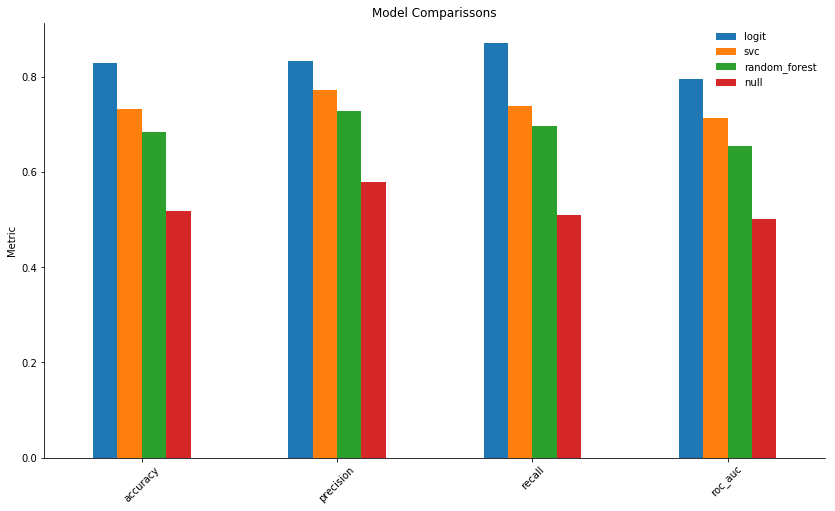

In [464]:
# Results
fig, ax = plt.subplots(figsize=(14, 8));
results_df.drop('balanced_accuracy').plot(kind='bar', ax=ax)
sns.despine();
plt.legend(frameon=False);
plt.xticks(rotation=45)
plt.title(r'Model Comparissons')
plt.ylabel('Metric');

plt.savefig('/userdata/kscangos/Subnets/Signals/SuperEEG/supereeg_figures/model_comparissons-logit_svc_rf-no_bal.pdf', 
            transparent=True)

# Sandbox

In [ ]:
clf = GridSearchCV(pipe, param_grid=param_grid, cv=cv, scoring=metric, refit='acc', n_jobs=n_jobs,
                   return_train_score=True, error_score=np.nan)
clf.fit(X, y);
pred = pipe.predict(X.iloc[test_idx])[0]
proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
preds.append(pred)
probs.append(proba)

bm = pd.DataFrame(list(zip(preds, probs, y.values.tolist())), columns=['pred', 'proba', 'actual'])

rs = recall_score(bm['actual'], bm['pred'])
ps = precision_score(bm['actual'], bm['pred'])
acc = accuracy_score(bm['actual'], bm['pred'])
bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
roc = roc_auc_score(bm['actual'], bm['proba'])

In [ ]:
metric = ''
clf = GridSearchCV(LogisticRegression(), param_grid=param_grid, cv=cv, scoring=metric, refit='acc', n_jobs=n_jobs,
                   return_train_score=True, error_score=np.nan)
clf.fit(X, y);

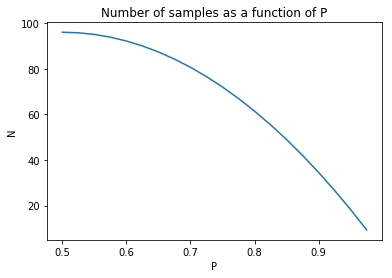

In [477]:
# n for logistic regression
p = np.arange(0.5, 1, 0.025)
error = 0.1
n = (1.96/error)**2 * p*(1-p)

plt.plot(p, n);
plt.xlabel('P');
plt.ylabel('N');
plt.title('Number of samples as a function of P');

In [549]:
logit = LogisticRegression(penalty='l1')
logit.fit(X, y)
print('score: {}'.format(logit.score(X, y)))

feats = pd.DataFrame(list(zip(logit.coef_[0], X.columns)), columns=['coef', 'feat'])
print(feats[feats.coef != 0])

score: 0.8048780487804879
       coef  feat
0  0.071583     0
1  0.093287     1
2 -0.780876     2
3  0.146095     3
5 -1.404489     5


/userdata/pdaly/.envs/mind/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [550]:
sfm = SelectFromModel(RandomForestClassifier(n_estimators=200), max_features=10)
sfm.fit(X, y)
X.columns[sfm.get_support()]

logit = LogisticRegression(penalty='l1')
logit.fit(X[X.columns[sfm.get_support()]], y)
print('score: {}'.format(logit.score(X[X.columns[sfm.get_support()]], y)))

feats = pd.DataFrame(list(zip(logit.coef_[0], X.columns[sfm.get_support()])), columns=['coef', 'feat'])
print(feats[feats.coef != 0])

score: 0.8292682926829268
       coef  feat
0  0.127172     1
1 -0.667565     2
2  0.198088     3
3 -1.362267     5


/userdata/pdaly/.envs/mind/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [551]:
sfm = SelectFromModel(LogisticRegression(), max_features=10)
sfm.fit(X, y)
X.columns[sfm.get_support()]

logit = LogisticRegression(penalty='l1')
logit.fit(X[X.columns[sfm.get_support()]], y)
print('score: {}'.format(logit.score(X[X.columns[sfm.get_support()]], y)))

feats = pd.DataFrame(list(zip(logit.coef_[0], X.columns[sfm.get_support()])), columns=['coef', 'feat'])
print(feats[feats.coef != 0])

score: 0.8048780487804879
       coef  feat
0 -0.867514     2
1  0.069784     3
2 -1.375050     5


/userdata/pdaly/.envs/mind/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)
/userdata/pdaly/.envs/mind/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [561]:
skb = SelectKBest(mutual_info_classif)
skb.fit(X, y)
X.columns[skb.get_support()]

logit = LogisticRegression(penalty='l1')
logit.fit(X[X.columns[skb.get_support()]], y)
print('score: {}'.format(logit.score(X[X.columns[skb.get_support()]], y)))

feats = pd.DataFrame(list(zip(logit.coef_[0], X.columns[skb.get_support()])), columns=['coef', 'feat'])
print(feats[feats.coef != 0])

score: 0.8048780487804879
       coef  feat
0 -0.867444     2
1  0.069806     3
2 -1.375044     5


/userdata/pdaly/.envs/mind/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [569]:
from sklearn.feature_selection import chi2, f_classif

In [572]:
preds = list()
probs = list()
for train_idx, test_idx in LeaveOneOut().split(X):
    pipe = Pipeline([('mut_inf', SelectKBest(f_classif)), 
                     ('clf', LogisticRegression(C=1, penalty='l1', class_weight='balanced', solver='liblinear',
                                                max_iter=5000, tol=1e-6))])
    pipe.fit(X.iloc[train_idx], y.iloc[train_idx])
    pred = pipe.predict(X.iloc[test_idx])[0]
    proba = pipe.predict_proba(X.iloc[test_idx])[0][1]
    preds.append(pred)
    probs.append(proba)

bm = pd.DataFrame(list(zip(preds, probs, y.values.tolist())), columns=['pred', 'proba', 'actual'])

rs = recall_score(bm['actual'], bm['pred'])
ps = precision_score(bm['actual'], bm['pred'])
acc = accuracy_score(bm['actual'], bm['pred'])
bacc = balanced_accuracy_score(bm['actual'], bm['pred'])
roc = roc_auc_score(bm['actual'], bm['proba'])

metric_results[model] = {'recall': rs, 'precision': ps, 'accuracy': acc, 'balanced_accuracy': bacc, 'roc_auc': roc}

print('Top 10 features via f_')
print('------------------------')
print('Recall       : {:1.3f}'.format(rs))
print('Precision    : {:1.3f}'.format(ps))
print('Accuracy     : {:1.3f}'.format(acc))
print('Bal. Accuracy: {:1.3f}'.format(bacc))
print('ROC AUC.     : {:1.3f}\n'.format(roc))

10
------------------------
Recall       : 0.870
Precision    : 0.833
Accuracy     : 0.829
Bal. Accuracy: 0.824
ROC AUC.     : 0.790



In [576]:
skb = SelectKBest(f_classif)
skb.fit(X, y)
X.columns[skb.get_support()]

logit = LogisticRegression(penalty='l1')
logit.fit(X[X.columns[skb.get_support()]], y)
print('score: {}'.format(logit.score(X[X.columns[skb.get_support()]], y)))

feats_ft = pd.DataFrame(list(zip(logit.coef_[0], X.columns[skb.get_support()])), columns=['coef', 'feat'])
print(feats[feats.coef != 0])

score: 0.8292682926829268
       coef  feat
0  0.127170     1
1 -0.667586     2
2  0.198067     3
4 -1.362231     5


/userdata/pdaly/.envs/mind/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [577]:
sfm = SelectFromModel(RandomForestClassifier(n_estimators=200), max_features=10)
sfm.fit(X, y)
X.columns[sfm.get_support()]

logit = LogisticRegression(penalty='l1')
logit.fit(X[X.columns[sfm.get_support()]], y)
print('score: {}'.format(logit.score(X[X.columns[sfm.get_support()]], y)))

feats_rf = pd.DataFrame(list(zip(logit.coef_[0], X.columns[sfm.get_support()])), columns=['coef', 'feat'])
print(feats[feats.coef != 0])

score: 0.8292682926829268
       coef  feat
0  0.127170     1
1 -0.667586     2
2  0.198067     3
4 -1.362231     5


/userdata/pdaly/.envs/mind/lib/python3.5/site-packages/sklearn/linear_model/logistic.py:432: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


In [589]:
ftz = feats_ft[feats_ft.coef != 0]
rfz = feats_rf[feats_rf.coef != 0]
np.allclose(ftz, rfz, rtol=1e-3)

True

In [586]:
feats_rf

,coef,feat
0,0.127184,1
1,-0.667527,2
2,0.198110,3
3,-1.362264,5
4,0.000000,7
5,0.000000,8
6,0.000000,14
7,0.000000,17
8,0.000000,20
9,0.000000,23
